In [64]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [4]:
# Load in csv dataset
df = pd.read_csv('data/spam.csv',delimiter=',',encoding='latin-1')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Text(0.5, 1.0, 'Number of ham and spam messages')

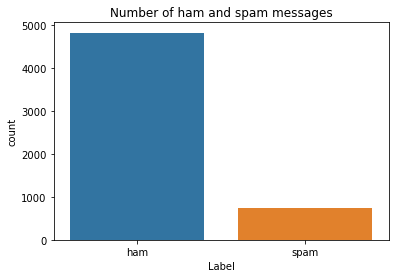

In [6]:
# See output distribution
sns.countplot(x=df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [7]:
# Get input and outputs
X = df.v2
Y = df.v1

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)
# print(len(Y_train))
# print(len(Y_test))
# print(len(Y_test)/(len(Y_train)+len(Y_test)))

In [9]:
maxLen = len(max(X_train, key=lambda x: len(x.split())).split())
maxLen

171

In [10]:
# Functions taken from emo_utils.py
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def convert_to_one_hot(Y, C):
    print('Y.reshape(-1)',Y.reshape(-1))
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [11]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [41]:
Y_train_NP = np.array(Y_train)
Y_test_NP = np.array(Y_test)

label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(Y_train_NP)
print(np.unique(vec))
print(np.unique(Y_train_NP))

# Y_oh_train = pd.get_dummies(Y_train)
# Y_oh_test = pd.get_dummies(Y_test)
# Y_oh_train_np = np.array(Y_oh_train)

# Stopped here TODO convert Y_train, Y_test to one_hot encodings. This is a binary classification problem.
# Y_oh_train = convert_to_one_hot(Y_train, C = 2)
# Y_oh_test = convert_to_one_hot(Y_test, C = 2)

[0 1]
['ham' 'spam']


In [24]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (J,), where J can be any number
    """
    # Get a valid word contained in the word_to_vec_map. 
    any_word = next(iter(word_to_vec_map.keys()))
    
    ### START CODE HERE ###
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    # Use `np.zeros` and pass in the argument of any word's word 2 vec's shape
    avg = np.zeros(word_to_vec_map[any_word].shape)
    
    # Initialize count to 0
    count = 0
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        # Check that word exists in word_to_vec_map
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            # Increment count
            count +=1
          
    if count > 0:
        # Get the average. But only if count > 0
        avg = avg/count
    
    ### END CODE HERE ###
    
    return avg

In [59]:
### YOU CANNOT EDIT THIS CELL

# BEGIN UNIT TEST
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)

def sentence_to_avg_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0], 
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])
        
    avg = target("a a_nw c_w a_s", word_to_vec_map)
    assert tuple(avg.shape) == tuple(word_to_vec_map['a'].shape),  "Check the shape of your avg array"  
    assert np.allclose(avg, [1.25, 2.5]),  "Check that you are finding the 4 words"
    avg = target("love a a_nw c_w a_s", word_to_vec_map)
    assert np.allclose(avg, [1.25, 2.5]), "Divide by count, not len(words)"
    avg = target("love", word_to_vec_map)
    assert np.array_equal(avg, [0, 0]), "Average of no words must give an array of zeros"
    avg = target("c_se foo a a_nw c_w a_s deeplearning c_nw", word_to_vec_map)
    assert np.allclose(avg, [0.1666667, 2.0]), "Debug the last example"
    
    print("\033[92mAll tests passed!")
    
sentence_to_avg_test(sentence_to_avg)

# END UNIT TEST

avg = 
 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]
All tests passed!


In [46]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    any_word = list(word_to_vec_map.keys())[0]
    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0] 
    
    for j in range(m):                       # Loop over training examples
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # Average words' vectors
        avg = np.zeros((n_h,))
        count = 0
        for w in words:
            if w in word_to_vec_map:
                avg += word_to_vec_map[w]
                count += 1
        
        if count > 0:
            avg = avg / count

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

In [77]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: model
# TODO vectorize this code

def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m,)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    # Get a valid word contained in the word_to_vec_map 
    any_word = next(iter(word_to_vec_map.keys()))
        
    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    label_encoder = LabelEncoder()
    Y_vec = label_encoder.fit_transform(Y_train_np)
    Y_oh = to_categorical(Y_vec)
    #Y_oh = pd.get_dummies(Y) #convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        
        cost = 0
        dW = 0
        db = 0
        
        for i in range(m):          # Loop over the training examples
            
            ### START CODE HERE ### (≈ 4 lines of code)
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)
#             print('avg',avg)

            # Forward propagate the avg through the softmax layer. 
            # You can use np.dot() to perform the multiplication.
            z = np.dot(W, avg) + b
#             print('z',z)
            a = softmax(z)
#             print('a',a)

            # Add the cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost += -np.sum(Y_oh[i] * np.log(a))
            ### END CODE HERE ###
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW += np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db += dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
            
        assert type(cost) == np.float64, "Incorrect implementation of cost"
        assert cost.shape == (), "Incorrect implementation of cost"
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

In [78]:
np.random.seed(1)
X_train_np = np.array(X_train)
Y_train_np = np.array(Y_train)

# label_encoder = LabelEncoder()
# Y_vec = label_encoder.fit_transform(Y_train_np)
# Y_oh = to_categorical(Y_vec)
# print(Y_train_np[0])
# print(Y_oh[0])

# print('X_train_np',X_train_np[111])
# print('Y_train_np',Y_train_np[111])
pred, W, b = model(X_train_np, Y_train_np, word_to_vec_map)

<ipython-input-77-c48f74fcca3f>:61: RuntimeWarning: divide by zero encountered in log
  cost += -np.sum(Y_oh[i] * np.log(a))
<ipython-input-77-c48f74fcca3f>:61: RuntimeWarning: invalid value encountered in multiply
  cost += -np.sum(Y_oh[i] * np.log(a))


Epoch: 0 --- cost = nan
Accuracy: 0.0
Epoch: 100 --- cost = nan
Accuracy: 0.0


KeyboardInterrupt: 